### Huffman : Compression des images

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DiouaneAbdallah/algorithme-dijkstra-en-python/blob/main/HuffmanCompression.ipynb)

---

In [1]:
import sys
import os
from math import ceil
import imageio
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

import numpy as np
from pylab import rcParams
rcParams['figure.figsize'] = 13, 5

# Définition  des classes HuffmanCompressor et HuffmanDecompressor pour faire la compression et la décompression

In [2]:
LEFT = '1'
RIGHT = '0'

class Leaf():
    def __init__(self, data, value):
        self.data = data
        self.value = value
        self.parent = None
        self.code = ''

    def __str__(self):
        return str(self.data)

    def __repr__(self):
        return self.__str__()

    def update_code(self, update):
        self.code = update + self.code

class Node():
    def __init__(self, left, right, value):
        self.value = value
        self.left = left
        self.right = right
        self.code = ''

        self.left.update_code(LEFT)
        self.right.update_code(RIGHT)

    def __str__(self):
        return str(self.value)

    def __repr__(self):
        return self.__str__()

    def update_code(self, update):
        self.code = update + self.code
        self.left.update_code(update)
        self.right.update_code(update)

def buildTree(byte_frequencies):
    tree = [Leaf(bf, bf[1]) for bf in byte_frequencies]

    leaves = []

    while len(tree) > 1:
        left, right = tree[:2]
        if type(left) is Leaf:
            leaves.append(left)
        if type(right) is Leaf:
            leaves.append(right)
        tree = tree[2:]
        node = Node(left, right, left.value + right.value)
        tree.append(node)
        tree = sorted(tree, key=lambda node: node.value)
        
    return leaves, tree[0]

class HuffmanCompressor():
    def __init__(self, filename):
        self.filename = filename
        self.outputname = filename.split('.')[0]

    def compress(self):
        all_bytes = []
        with open(self.filename, 'rb') as binaryfile:
            all_bytes = binaryfile.read()
                        
        byte_frequencies = self.getFrequencies(all_bytes)
                
        leaves, _ = buildTree(byte_frequencies)
        
        symbol_map = {leaf.data[0]:leaf.code for leaf in leaves}
        
        output_bits = '1'
        for b in all_bytes:
            output_bits = output_bits + symbol_map[b]
        
        
        byte_count = (len(output_bits)+7) // 8

        output_int = int(output_bits, 2)
        
        output_bytes = output_int.to_bytes(byte_count, sys.byteorder)
        
        max_count_bytes = ceil(leaves[-1].data[1].bit_length()/8)
                
        header_bytes = len(leaves).to_bytes(2, sys.byteorder)
        
        header_bytes += max_count_bytes.to_bytes(8, sys.byteorder)
        
        for leaf in leaves:
            header_bytes += (leaf.data[0].to_bytes(1, sys.byteorder))
            header_bytes += leaf.data[1].to_bytes(max_count_bytes, sys.byteorder)

        with open(self.outputname, 'wb') as out_file:
            out_file.write(header_bytes)
            out_file.write(output_bytes)

        CR = (len(output_bytes)+len(header_bytes)) / len(all_bytes)
        
        return (1-CR)*100    
    
    def getFrequencies(self, all_bytes):
        byte_set = set(all_bytes)

        byte_frequencies_dict = {b:0 for b in byte_set}

        for b in all_bytes:
            byte_frequencies_dict[b] = byte_frequencies_dict[b] + 1

        return sorted([item for item in byte_frequencies_dict.items()], key=lambda item:item[1])
    
class HuffmanDecompressor():
    def __init__(self, filename):
        self.filename = filename.split('.')[0]
        self.outputname = filename.split('.')[0] +'Dec.jpg'

    def decompress(self):
        input_bytes, byte_frequencies = self.readFile()
        _, tree = buildTree(byte_frequencies)
        input_bits = bin(int.from_bytes(input_bytes, sys.byteorder))[3:]
        output_bytes = b''
        current_node = tree
        for bit in input_bits:
            if bit == LEFT:
                current_node = current_node.left
            else:
                current_node = current_node.right

            if type(current_node) is Leaf:
                output_bytes += current_node.data[0]
                current_node = tree

        with open(self.outputname, 'wb') as output_file:
            output_file.write(output_bytes)

    def readFile(self):
        byte_frequencies = []
        input_bytes = None
        with open(self.filename, 'rb') as input_file:
            leaves_count = int.from_bytes(input_file.read(2), sys.byteorder)
            max_count_bytes = int.from_bytes(input_file.read(8), sys.byteorder)
            while leaves_count > 0:
                b = input_file.read(1)
                c = int.from_bytes(input_file.read(max_count_bytes), sys.byteorder)
                byte_frequencies.append((b,c))
                leaves_count -= 1
            input_bytes = input_file.read()
        return input_bytes, byte_frequencies

# Test des performances

In [3]:
image1 = 'images/pingpong.bmp'
image2 = 'images/voiture.bmp'
image3 = 'images/manette.bmp'
image4 = 'images/simba.bmp'
image5 = 'images/fruits.bmp'
image6 = 'images/cartes.bmp'

In [4]:
images = [image1, image2, image3, image4, image5, image6]

In [5]:
for image in images:
    compressor = HuffmanCompressor(image)
    compressor.compress()

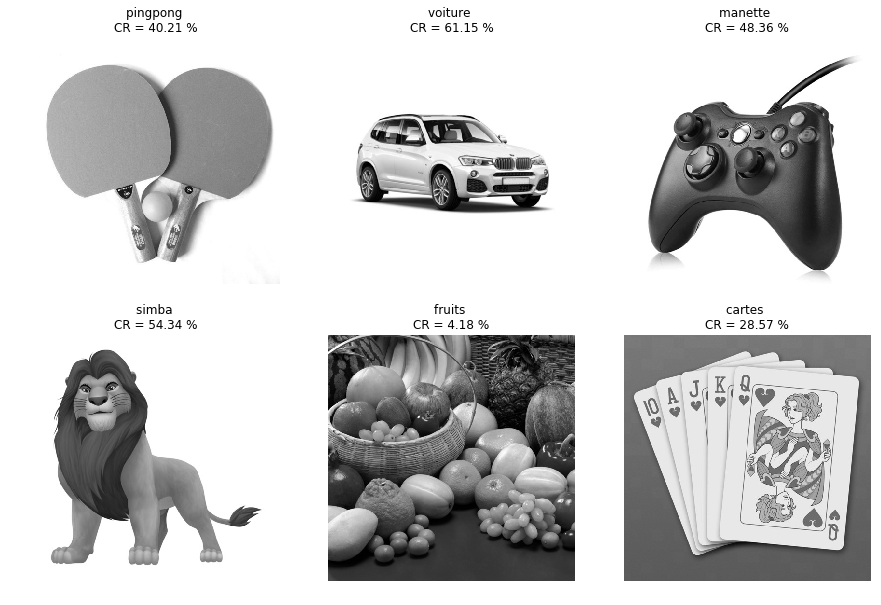

In [7]:
fig = plt.figure(figsize=(15, 10))

CRs = []

for i in range(1, 7):
    plt.subplot(2, 3, i)
    plt.axis('off')
    plt.imshow( imageio.imread(images[i-1]) )
    
    compressor = HuffmanCompressor(images[i-1])
    decompressor = HuffmanDecompressor(images[i-1])
    
    image = images[i-1].split('/')[1].split('.')[0]
    CR = compressor.compress()
    decompressor.decompress()
    CRs.append(CR)
    plt.title("%s \nCR = %.2f %%" % (image, CR))